In [141]:
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------------
# 1) Etapa de colecta de Dados (Normalização de nomes de colunas)
# -----------------------------------------------------------------
# Leitura de arquivos CSV usando pandas.

CAMINHO_CONTINENTES = "/home/avindo/Projecto_final/turismo_angola_paises_2010_2023.csv"
CAMINHO_PROV = "/home/avindo/Projecto_final/turismo_angola_provincias_2010_2023.csv"

cont = pd.read_csv(CAMINHO_CONTINENTES)
df_prov = pd.read_csv(CAMINHO_PROV)

print("---- Continentes---- ")
display(cont)
print("---- Províncias----")
display (prov)


---- Continentes---- 


,Ano,Pais,Chegadas_Turistas,Saidas_Turistas
0,2010,Portugal,10331,9293
1,2010,Brasil,17849,15793
2,2010,China,22088,18861
3,2010,África do Sul,13066,12370
4,2010,Namíbia,15328,13677
...,...,...,...,...
135,2023,Cuba,8454,7668
136,2023,Espanha,5952,5646
137,2023,França,8108,7084
138,2023,EUA,3756,3250


---- Províncias----


'Luanda'

In [142]:
# Padronização de nomes de colunas
df_prov.columns = df_prov.columns.str.strip().str.lower().str.normalize('NFKD') \
        .str.encode('ascii', errors='ignore').str.decode('utf-8')
cont.columns = cont.columns.str.strip().str.lower().str.normalize('NFKD') \
        .str.encode('ascii', errors='ignore').str.decode('utf-8')

        
# -------------------------------------------------------------
# 1.2) Limpeza e verificação de valores ausentes
# -------------------------------------------------------------
print('\n--- Missing values (continentes) ---')
print(cont.isnull().sum())

print('\n--- Missing values (províncias) ---')
print(df_prov.isnull().sum())
   


--- Missing values (continentes) ---
ano                  0
pais                 0
chegadas_turistas    0
saidas_turistas      0
dtype: int64

--- Missing values (províncias) ---
ano                  0
provincia            0
chegadas_turistas    0
saidas_turistas      0
variacao_%           0
dtype: int64


In [143]:
#1.3 Limpeza de Dados

# Remove linhas com valores ausentes
cont = cont.dropna()
df_prov = df_prov.dropna()

# -------------------------------------------------------------
# 1.3) Conversão de tipos numéricos
# -------------------------------------------------------------
for col in ['ano', 'chegadas_turistas', 'saidas_turistas', 'variacao(%)']:
    if col in cont.columns:
        cont[col] = pd.to_numeric(cont[col], errors='coerce')

for col in ['ano', 'chegadas_turistas', 'saidas_turistas']:
    if col in df_prov.columns:
        df_prov[col] = pd.to_numeric(df_prov[col], errors='coerce')

cont = cont.dropna()
df_prov = df_prov.dropna()


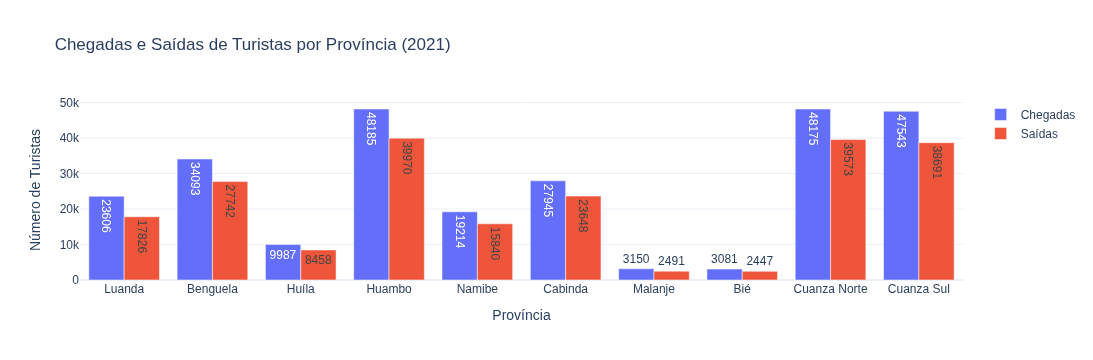

In [145]:
import plotly.graph_objects as go
import numpy as np

# Verifica se a coluna 'provincia' existe
if 'provincia' in df_prov.columns:
    provincias = df_prov['provincia'].unique()
    dados_2021 = df_prov[df_prov['ano'] == 2021]

    # Prepara os dados, preenchendo zeros se houver NAs
    chegadas = dados_2021.set_index('provincia').reindex(provincias)['chegadas_turistas'].fillna(0).values
    saidas = dados_2021.set_index('provincia').reindex(provincias)['saidas_turistas'].fillna(0).values

    # Cria gráfico de barras
    fig = go.Figure()

    largura = 0.4  # largura relativa da barra

    fig.add_trace(go.Bar(
        x=provincias,
        y=chegadas,
        name='Chegadas',
        width=largura,
        text=[int(v) for v in chegadas],
        textposition='auto'
    ))

    fig.add_trace(go.Bar(
        x=provincias,
        y=saidas,
        name='Saídas',
        width=largura,
        text=[int(v) for v in saidas],
        textposition='auto'
    ))

    # Layout
    fig.update_layout(
        title='Chegadas e Saídas de Turistas por Província (2021)',
        xaxis_title='Província',
        yaxis_title='Número de Turistas',
        barmode='group',  # barras lado a lado
        template='plotly_white'
    )

    fig.show()


In [148]:
#1.5 Engenharia de Recursos
    #• Criação de agregados por ano para análises nacionais.

# 4.2 Preparar dados agregados por ano (soma de todos continentes/províncias)
agg_por_ano = cont.groupby('ano')[['chegadas_turistas', 'saidas_turistas']].sum().reset_index()

print('\n--- Agregado por ano (continentes) ---')
print(agg_por_ano)



--- Agregado por ano (continentes) ---
     ano  chegadas_turistas  saidas_turistas
0   2010             153842           137474
1   2011             188683           169265
2   2012             168920           151784
3   2013             141637           126174
4   2014             108799            99850
5   2015             106370            96618
6   2016             134399           123686
7   2017             136612           122549
8   2018             205015           186777
9   2019             135593           122046
10  2020              86653            76178
11  2021             247370           220485
12  2022             200702           179767
13  2023              64467            57741

--- Agregado por ano (Provincia) ---
     ano  chegadas_turistas  saidas_turistas
0   2010             220512           172842
1   2011             178254           141662
2   2012             246598           197635
3   2013             231835           189236
4   2014             3

In [149]:
#2. Exploração de Modelos e  Avaliação do Modelo

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error

# Usaremos 'ano' como variável explicativa simples (X) e 'chegadas_turistas' como target (y)
X = agg_por_ano[['ano']].values
y = agg_por_ano['chegadas_turistas'].values

models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=200, random_state=42)
}

results = {}
if len(X) >= 3:
    tscv = TimeSeriesSplit(n_splits=3)
else:
    tscv = None

for name, model in models.items():
    if name not in results:
        results[name] = {}

    if tscv is not None:
        scores = cross_val_score(model, X, y, cv=tscv, scoring='r2')
        results[name]['r2_cv_mean'] = scores.mean()
        results[name]['r2_cv_std'] = scores.std()

    model.fit(X, y)
    y_pred = model.predict(X)
    results[name]['r2_insample'] = r2_score(y, y_pred)
    results[name]['rmse_insample'] = np.sqrt(mean_squared_error(y, y_pred))

print("\n--- Resultados dos modelos (agregado nacional) ---")
display(results)



--- Resultados dos modelos (agregado nacional) ---


{'LinearRegression': {'r2_cv_mean': np.float64(-2.4090330974092065),
  'r2_cv_std': np.float64(2.779264542893903),
  'r2_insample': 0.002579246653242717,
  'rmse_insample': np.float64(48153.08198898585)},
 'RandomForest': {'r2_cv_mean': np.float64(-0.26409537517598397),
  'r2_cv_std': np.float64(0.26794676702564735),
  'r2_insample': 0.8287477926739731,
  'rmse_insample': np.float64(19952.75995508686)}}

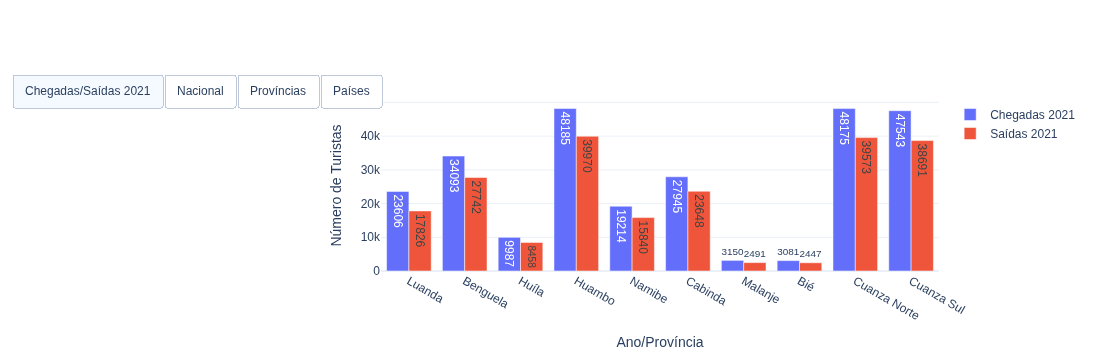

In [150]:
import plotly.graph_objects as go
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# -----------------------------
# Dados de exemplo
# -----------------------------
# agg_por_ano: df com 'ano', 'chegadas_turistas', 'saidas_turistas'
# prov: df com 'provincia', 'ano', 'chegadas_turistas', 'saidas_turistas'
# cont: df com 'pais', 'ano', 'chegadas_turistas'
# models: dict com modelos treinados para previsões nacionais

anos_futuros_nacional = np.arange(2022, 2026)

fig = go.Figure()

# -----------------------------
# 1) Chegadas e saídas 2021 por província
# -----------------------------
if 'provincia' in df_prov.columns:
    provincias = df_prov['provincia'].unique()
    dados_2021 =df_prov[df_prov['ano'] == 2021]
    chegadas = dados_2021.set_index('provincia').reindex(provincias)['chegadas_turistas'].fillna(0).values
    saidas = dados_2021.set_index('provincia').reindex(provincias)['saidas_turistas'].fillna(0).values

    fig.add_trace(go.Bar(
        x=provincias,
        y=chegadas,
        name='Chegadas 2021',
        text=[int(v) for v in chegadas],
        textposition='auto',
        visible=True
    ))

    fig.add_trace(go.Bar(
        x=provincias,
        y=saidas,
        name='Saídas 2021',
        text=[int(v) for v in saidas],
        textposition='auto',
        visible=True
    ))

# -----------------------------
# 2) Previsões Nacionais
# -----------------------------
# Dados reais
fig.add_trace(go.Scatter(
    x=agg_por_ano['ano'],
    y=agg_por_ano['chegadas_turistas'],
    mode='lines+markers',
    name='Chegadas Reais',
    line=dict(color='black', width=2),
    visible=False
))

# Previsões
if isinstance(models, dict):
    for name, model in models.items():
        preds = model.predict(anos_futuros_nacional.reshape(-1,1))
        fig.add_trace(go.Scatter(
            x=anos_futuros_nacional,
            y=preds,
            mode='lines+markers',
            name=f'Previsão {name}',
            line=dict(dash='dash'),
            visible=False
        ))
else:
    preds = models.predict(anos_futuros_nacional.reshape(-1,1))
    fig.add_trace(go.Scatter(
        x=anos_futuros_nacional,
        y=preds,
        mode='lines+markers',
        name='Previsão',
        line=dict(dash='dash'),
        visible=False
    ))

# -----------------------------
# 3) Previsões por Província
# -----------------------------
prov_selec = ['Luanda','Benguela','Huíla']
for prov_name in prov_selec:
    dados_prov = df_prov[df_prov['provincia']==prov_name]
    
    # Dados reais
    fig.add_trace(go.Scatter(
        x=dados_prov['ano'],
        y=dados_prov['chegadas_turistas'],
        mode='lines+markers',
        name=f'{prov_name} Reais',
        visible=False
    ))
    
    # Previsão com RandomForest
    X_future = np.arange(dados_prov['ano'].max()+1, 2026).reshape(-1,1)
    modelo = RandomForestRegressor(random_state=42)
    modelo.fit(dados_prov[['ano']], dados_prov['chegadas_turistas'])
    preds = modelo.predict(X_future)
    
    fig.add_trace(go.Scatter(
        x=X_future.flatten(),
        y=preds,
        mode='lines+markers',
        name=f'{prov_name} Previsão',
        line=dict(dash='dash'),
        visible=False
    ))

# -----------------------------
# 4) Previsões por País/Continente
# -----------------------------
pais_selec = ['Portugal','Brasil','China']
for pais_name in pais_selec:
    dados_pais = cont[cont['pais']==pais_name]
    
    # Dados reais
    fig.add_trace(go.Scatter(
        x=dados_pais['ano'],
        y=dados_pais['chegadas_turistas'],
        mode='lines+markers',
        name=f'{pais_name} Reais',
        visible=False
    ))
    
    # Previsão com RandomForest
    X_future = np.arange(dados_pais['ano'].max()+1, 2026).reshape(-1,1)
    modelo = RandomForestRegressor(random_state=42)
    modelo.fit(dados_pais[['ano']], dados_pais['chegadas_turistas'])
    preds = modelo.predict(X_future)
    
    fig.add_trace(go.Scatter(
        x=X_future.flatten(),
        y=preds,
        mode='lines+markers',
        name=f'{pais_name} Previsão',
        line=dict(dash='dash'),
        visible=False
    ))

# -----------------------------
# Botões interativos para alternar abas
# -----------------------------
num_nacional = len(models) + 1 if isinstance(models, dict) else 2
num_prov = len(prov_selec)*2
num_pais = len(pais_selec)*2

fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            active=0,
            x=0.0,
            y=1.15,
            buttons=list([
                dict(label="Chegadas/Saídas 2021",
                     method="update",
                     args=[{"visible": [True]*2 + [False]*(len(fig.data)-2)},
                           {"title": "Chegadas e Saídas por Província (2021)"}]),
                dict(label="Nacional",
                     method="update",
                     args=[{"visible": [False]*2 + [True]*num_nacional + [False]*(len(fig.data)-2-num_nacional)},
                           {"title": "Chegadas Reais e Previsões Nacionais (2022–2025)"}]),
                dict(label="Províncias",
                     method="update",
                     args=[{"visible": [False]*2 + [False]*num_nacional + [True]*num_prov + [False]*(len(fig.data)-2-num_nacional-num_prov)},
                           {"title": "Chegadas Reais e Previsões por Província (2022–2025)"}]),
                dict(label="Países",
                     method="update",
                     args=[{"visible": [False]*2 + [False]*num_nacional + [False]*num_prov + [True]*num_pais},
                           {"title": "Chegadas Reais e Previsões por País/Continente (2022–2025)"}])
            ]),
        )
    ]
)

# Layout geral
fig.update_layout(
    template='plotly_white',
    xaxis_title='Ano/Província',
    yaxis_title='Número de Turistas',
    showlegend=True
)

fig.show()


In [155]:
from sklearn.linear_model import LinearRegression
import numpy as np

prov_models = {}
anos_future = np.arange(2022, 2030)
prov_previsoes = {}

for prov_name in df_prov['provincia'].unique():  # usa prov_name aqui
    sub = df_prov[df_prov['provincia'] == prov_name].sort_values('ano')
    if sub.shape[0] < 2:
        continue  # Sem dados suficientes
    Xprov = sub[['ano']].values
    yprov = sub['chegadas_turistas'].values
    m = LinearRegression()
    m.fit(Xprov, yprov)
    prov_models[prov_name] = m
    prov_previsoes[prov_name] = m.predict(anos_future.reshape(-1,1))

# Mostra algumas previsões de exemplo
print('\n--- Previsões por província (exemplo 2022-2030) ---')
for prov_name, preds in list(prov_previsoes.items())[:10]:
    display(prov_name, '->', [int(p) for p in preds])



--- Previsões por província (exemplo 2022-2030) ---


'Luanda'

'->'

[27407, 27531, 27655, 27779, 27903, 28027, 28151, 28275]

'Benguela'

'->'

[30911, 31102, 31294, 31485, 31677, 31869, 32060, 32252]

'Huíla'

'->'

[17201, 16220, 15239, 14259, 13278, 12297, 11316, 10335]

'Huambo'

'->'

[27259, 27588, 27918, 28248, 28578, 28908, 29237, 29567]

'Namibe'

'->'

[14346, 13400, 12453, 11506, 10559, 9613, 8666, 7719]

'Cabinda'

'->'

[38964, 41455, 43946, 46437, 48927, 51418, 53909, 56400]

'Malanje'

'->'

[21495, 20597, 19698, 18799, 17900, 17002, 16103, 15204]

'Bié'

'->'

[37801, 39792, 41782, 43772, 45762, 47752, 49742, 51732]

'Cuanza Norte'

'->'

[32144, 33093, 34042, 34991, 35941, 36890, 37839, 38788]

'Cuanza Sul'

'->'

[33692, 34891, 36091, 37290, 38490, 39689, 40889, 42089]

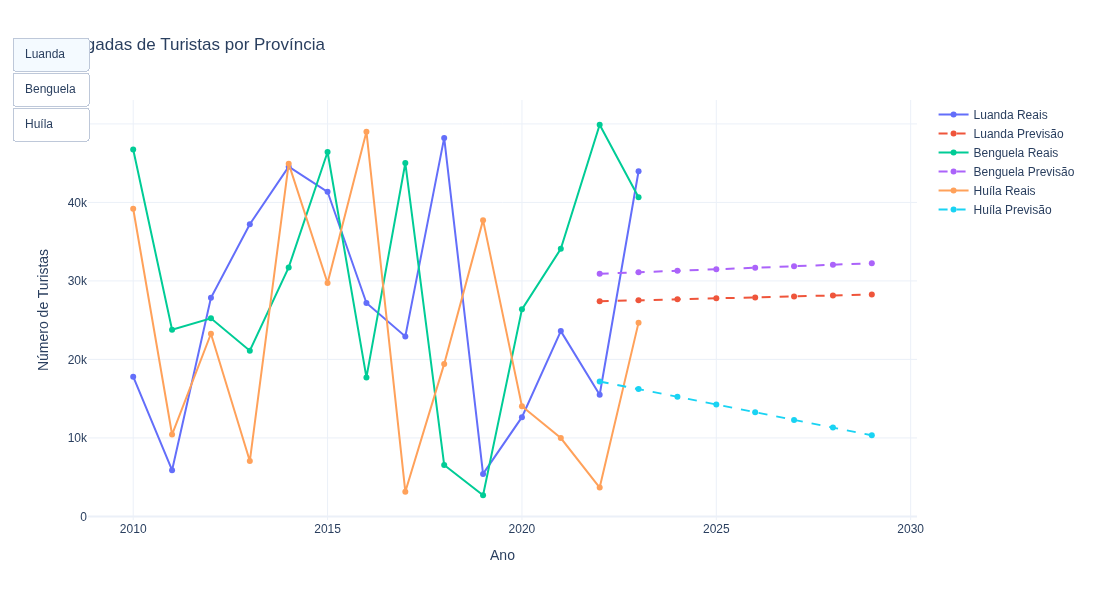

In [154]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure()
anos_future = np.arange(2022, 2030)

# Lista de províncias que você quer mostrar primeiro
prov_list = ['Luanda','Benguela','Huíla']

for prov_name in prov_list:
    sub = df_prov[df_prov['provincia'] == prov_name].sort_values('ano')
    if sub.shape[0] < 1:
        continue
    # Dados reais
    fig.add_trace(go.Scatter(
        x=sub['ano'], y=sub['chegadas_turistas'],
        mode='lines+markers', name=f'{prov_name} Reais',
        visible=True
    ))
    # Previsões
    preds = prov_previsoes.get(prov_name)
    if preds is not None:
        fig.add_trace(go.Scatter(
            x=anos_future, y=preds,
            mode='lines+markers', name=f'{prov_name} Previsão',
            line=dict(dash='dash'), visible=True
        ))

# Botões interativos para alternar províncias
buttons = []
for i, prov_name in enumerate(prov_list):
    visible = [False] * len(fig.data)
    visible[i*2] = True       # Dados reais
    visible[i*2+1] = True     # Previsões
    buttons.append(dict(label=prov_name,
                        method='update',
                        args=[{'visible': visible},
                              {'title': f'Chegadas de Turistas: {prov_name}'}]))

fig.update_layout(
    updatemenus=[dict(type='buttons', buttons=buttons, x=0, y=1.15)],
    title='Chegadas de Turistas por Província',
    xaxis_title='Ano',
    yaxis_title='Número de Turistas',
    template='plotly_white',
    width=1000,
    height=600
)

fig.show()


In [ ]:
# -------------------------------------------------------------
# 6) Salvamento em CSV
# -------------------------------------------------------------
out = pd.DataFrame({'ano': anos_future})
for prov_name, preds in prov_previsoes.items():
    out[f'previsao_{prov_name}'] = [int(p) for p in preds]

out.to_csv('previsoes_chegadas_2022_2030.csv', index=False)
print('\nArquivo "previsoes_chegadas_2022_2030.csv" salvo no diretório atual.')
